In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
import pandas as pd
import numpy as np
from PIL import Image
import torchvision.transforms as transforms
from torchvision.models import resnet50
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
import json
import random
import math
import time
from datetime import datetime

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

# Get current GPU information
current_gpu = torch.cuda.current_device()
print(f"Using GPU: {current_gpu}")
print(f"GPU name: {torch.cuda.get_device_name(current_gpu)}")

# Memory usage for current GPU
allocated = torch.cuda.memory_allocated(current_gpu) / 1024**3  # Convert to GB
reserved = torch.cuda.memory_reserved(current_gpu) / 1024**3    # Convert to GB
max_allocated = torch.cuda.max_memory_allocated(current_gpu) / 1024**3

print(f"Memory allocated: {allocated:.2f} GB")
print(f"Memory reserved: {reserved:.2f} GB") 
print(f"Max memory allocated: {max_allocated:.2f} GB")

Using GPU: 0
GPU name: NVIDIA RTX A5000
Memory allocated: 0.13 GB
Memory reserved: 16.44 GB
Max memory allocated: 14.04 GB


Setting up PAPER baseline model with checkpointing...
Using device: cuda:0
Available GPU VRAM: 23.6 GB
Creating datasets using official train_val_list.txt and test_list.txt...
Test images: 25596
Train+Val images: 86524
Train images: 69219
Validation images: 17305
Dataset initialized with 69219 images
Dataset initialized with 17305 images
Dataset initialized with 25596 images
Train dataset size: 69219
Validation dataset size: 17305
Test dataset size: 25596

Class distribution in training dataset:
  Atelectasis: 6575 (9.50%)
  Cardiomegaly: 1348 (1.95%)
  Effusion: 6896 (9.96%)
  Infiltration: 11034 (15.94%)
  Mass: 3226 (4.66%)
  Nodule: 3787 (5.47%)
  Pneumonia: 696 (1.01%)
  Pneumothorax: 2098 (3.03%)
  Consolidation: 2244 (3.24%)
  Edema: 1122 (1.62%)
  Emphysema: 1127 (1.63%)
  Fibrosis: 984 (1.42%)
  Pleural_Thickening: 1765 (2.55%)
  Hernia: 110 (0.16%)
Using Paper Baseline Model (ResNet-50 with transition layer + LSE pooling)...
Resuming training from checkpoint: checkpoints1/che

/tmp/ipykernel_9639/3352041538.py:331: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=Config.device)


Checkpoint loaded: checkpoints1/checkpoint_epoch_100.pth
Resuming from epoch 101, Best AUC: 0.7796
Checkpoint timestamp: 2025-11-08 16:06:25
Checkpoint saved: checkpoints1/checkpoint_epoch_100.pth
Evaluating on test set...

FINAL TEST RESULTS (PAPER BASELINE)
Test Loss: 13.6428
Test Average AUC: 0.7369

Per-class Test AUC:
  Atelectasis: 0.7078
  Cardiomegaly: 0.8273
  Effusion: 0.7710
  Infiltration: 0.6793
  Mass: 0.6991
  Nodule: 0.6585
  Pneumonia: 0.6462
  Pneumothorax: 0.7812
  Consolidation: 0.7024
  Edema: 0.7911
  Emphysema: 0.7474
  Fibrosis: 0.7586
  Pleural_Thickening: 0.7093
  Hernia: 0.8373

Final model saved as 'final_paper_baseline_model.pth'


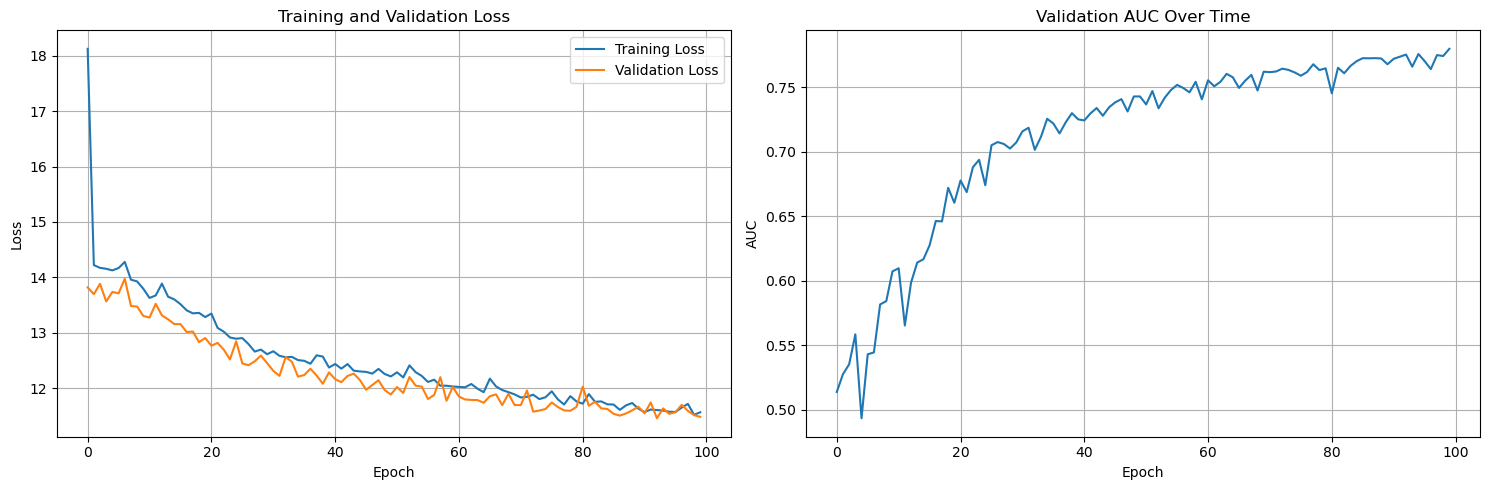


TRAINING COMPLETE WITH CHECKPOINTING
Checkpoint features:
Automatic resume from latest checkpoint
Regular checkpoint saving every N epochs
Best model tracking
Old checkpoint cleanup
Training history preservation
Final Test AUC: 0.7369


: 

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import torch

# Get current GPU information
current_gpu = torch.cuda.current_device()

# Configuration matching the paper
class Config:
    data_dir = "/data1/home/prakrutp/medical_imaging/dataset"  # Base directory
    csv_path = "/data1/home/prakrutp/medical_imaging/dataset/Data_Entry_2017.csv"
    image_size = 512  # Paper uses 1024x1024
    batch_size = 32  # Reduced for memory constraints
    num_epochs = 100
    learning_rate = 0.001
    num_classes = 14
    device = torch.device(f'cuda:{current_gpu}' if torch.cuda.is_available() else 'cpu') #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Paper-specific parameters
    lse_pooling_r = 10
    feature_dim = 2048
    spatial_size = 32
    
    # Split files
    test_list_file = "test_list.txt"
    train_val_list_file = "train_val_list.txt"
    
    # Checkpoint settings
    checkpoint_dir = "checkpoints1"
    checkpoint_interval = 5  # Save checkpoint every N epochs
    resume_training = True   # Set to False to start from scratch

# Create checkpoint directory
os.makedirs(Config.checkpoint_dir, exist_ok=True)

# Updated Dataset class for distributed folder structure
class ChestXrayDataset(Dataset):
    def __init__(self, csv_file, base_dir, image_list=None, transform=None):
        """
        Args:
            csv_file: Path to the Data_Entry_2017.csv file
            base_dir: Base directory containing images_001, images_002, etc.
            image_list: List of image filenames to include (from train_val_list.txt or test_list.txt)
            transform: Image transforms
        """
        self.df = pd.read_csv(csv_file)
        self.base_dir = base_dir
        self.transform = transform
        
        # Define the 14 disease classes
        self.disease_classes = [
            'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 
            'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 
            'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 
            'Pleural_Thickening', 'Hernia'
        ]
        
        # Create label columns
        self._create_label_columns()
        
        # Filter dataset based on image_list if provided
        if image_list is not None:
            self.data_frame = self.df[self.df['Image Index'].isin(image_list)].reset_index(drop=True)
        else:
            self.data_frame = self.df
        
        print(f"Dataset initialized with {len(self.data_frame)} images")
        
    def _create_label_columns(self):
        """Create binary label columns for each disease"""
        for disease in self.disease_classes:
            self.df.loc[:, disease] = self.df['Finding Labels'].apply(
                lambda x: 1 if disease in x else 0
            )
    
    def _find_image_path(self, img_name):
        """Find the actual path of an image in the distributed folders"""
        # Try different folder patterns
        for i in range(1, 13):
            folder_name = f"images_{i:03d}"  # images_001, images_002, etc.
            possible_path = os.path.join(self.base_dir, folder_name, "images", img_name)
            if os.path.exists(possible_path):
                return possible_path
        
        # If not found in any folder, return the first possible path for error handling
        return os.path.join(self.base_dir, "images_001", "images", img_name)
    
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, idx):
        img_name = self.data_frame.iloc[idx]['Image Index']
        img_path = self._find_image_path(img_name)
        
        # Load image
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Warning: Could not load image {img_path}: {e}")
            # Create a black image as fallback
            image = Image.new('RGB', (Config.image_size, Config.image_size), color='black')
        
        # Get labels for all 14 diseases
        labels = []
        for disease in self.disease_classes:
            labels.append(self.data_frame.iloc[idx][disease])
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.FloatTensor(labels)
    
    def get_class_distribution(self):
        """Get the distribution of each disease in the dataset"""
        distribution = {}
        for disease in self.disease_classes:
            count = self.data_frame[disease].sum()
            percentage = (count / len(self.data_frame)) * 100
            distribution[disease] = {'count': count, 'percentage': percentage}
        return distribution

# Helper functions to load split files
def load_split_file(file_path):
    """Load image names from split files"""
    with open(file_path, 'r') as f:
        image_names = [line.strip() for line in f.readlines()]
    return image_names

def create_datasets_from_splits(csv_file, base_dir, test_list_file, train_val_list_file, transform=None):
    """
    Create train, validation, and test datasets using the provided split files
    """
    # Load split files
    test_images = load_split_file(test_list_file)
    train_val_images = load_split_file(train_val_list_file)
    
    print(f"Test images: {len(test_images)}")
    print(f"Train+Val images: {len(train_val_images)}")
    
    # Split train_val into train and validation (80% train, 20% val)
    train_images, val_images = train_test_split(
        train_val_images, test_size=0.2, random_state=42
    )
    
    print(f"Train images: {len(train_images)}")
    print(f"Validation images: {len(val_images)}")
    
    # Create datasets
    train_dataset = ChestXrayDataset(
        csv_file=csv_file,
        base_dir=base_dir,
        image_list=train_images,
        transform=transform
    )
    
    val_dataset = ChestXrayDataset(
        csv_file=csv_file,
        base_dir=base_dir,
        image_list=val_images,
        transform=transform
    )
    
    test_dataset = ChestXrayDataset(
        csv_file=csv_file,
        base_dir=base_dir,
        image_list=test_images,
        transform=transform
    )
    
    return train_dataset, val_dataset, test_dataset

# LSE Pooling Layer from the paper
class LSEPooling(nn.Module):
    def __init__(self, r=10):
        super(LSEPooling, self).__init__()
        self.r = r
        
    def forward(self, x):
        # x shape: (batch_size, channels, height, width)
        batch_size, channels, height, width = x.shape
        
        # Reshape for pooling
        x = x.view(batch_size, channels, -1)  # (batch_size, channels, height*width)
        
        # LSE pooling as defined in paper
        x_max, _ = torch.max(x, dim=2, keepdim=True)
        
        # Stable LSE computation (equation 3 in paper)
        exp_x = torch.exp(self.r * (x - x_max))
        sum_exp = torch.sum(exp_x, dim=2, keepdim=True)
        x_pooled = x_max + (1.0 / self.r) * torch.log((1.0 / (height * width)) * sum_exp)
        
        return x_pooled.squeeze(2)  # (batch_size, channels)

# Paper's Baseline Model (ResNet-50 with transition layer and LSE pooling)
class PaperBaselineModel(nn.Module):
    def __init__(self, num_classes=14):
        super(PaperBaselineModel, self).__init__()
        
        # Load pre-trained ResNet-50
        self.backbone = resnet50(weights='DEFAULT')
        
        # Remove the final fully connected layer and avgpool
        self.features = nn.Sequential(*list(self.backbone.children())[:-2])
        
        # Transition layer to get uniform feature dimension
        self.transition_layer = nn.Conv2d(2048, Config.feature_dim, kernel_size=1)
        
        # Global pooling layer (LSE pooling from paper)
        self.global_pool = LSEPooling(r=Config.lse_pooling_r)
        
        # Prediction layer
        self.prediction_layer = nn.Linear(Config.feature_dim, num_classes)
        
        # Sigmoid for multi-label classification
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights for new layers
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        # Feature extraction
        features = self.features(x)
        
        # Transition layer
        features = self.transition_layer(features)
        
        # Global pooling
        pooled = self.global_pool(features)
        
        # Prediction
        output = self.prediction_layer(pooled)
        
        # Sigmoid activation for multi-label
        output = self.sigmoid(output)
        
        return output

# Paper's Weighted Cross Entropy Loss
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(WeightedCrossEntropyLoss, self).__init__()
    
    def forward(self, outputs, targets):
        """
        Weighted Cross Entropy Loss as defined in paper (Equation 1)
        L_W-CEL = β_P * Σ_{y_c=1} -ln(f(x_c)) + β_N * Σ_{y_c=0} -ln(1 - f(x_c))
        """
        batch_size, num_classes = targets.shape
        
        # Compute weights based on batch statistics (as in paper)
        num_pos = torch.sum(targets, dim=0)
        num_neg = batch_size - num_pos
        
        # Avoid division by zero
        num_pos = torch.clamp(num_pos, min=1)
        num_neg = torch.clamp(num_neg, min=1)
        
        beta_P = (num_pos + num_neg) / num_pos
        beta_N = (num_pos + num_neg) / num_neg
        
        # Expand weights to match batch dimensions
        beta_P = beta_P.unsqueeze(0).expand(batch_size, -1)
        beta_N = beta_N.unsqueeze(0).expand(batch_size, -1)
        
        # Cross entropy terms
        pos_loss = -targets * torch.log(outputs + 1e-8)
        neg_loss = -(1 - targets) * torch.log(1 - outputs + 1e-8)
        
        # Apply weights
        weighted_pos_loss = beta_P * pos_loss
        weighted_neg_loss = beta_N * neg_loss
        
        # Sum over classes and average over batch
        loss = torch.mean(torch.sum(weighted_pos_loss + weighted_neg_loss, dim=1))
        
        return loss

# Checkpoint Management Functions
def save_checkpoint(epoch, model, optimizer, train_losses, val_losses, val_auc_scores, 
                   best_auc, is_best=False, checkpoint_type="regular"):
    """Save training checkpoint"""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_auc_scores': val_auc_scores,
        'best_auc': best_auc,
        'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'config': {
            'image_size': Config.image_size,
            'batch_size': Config.batch_size,
            'learning_rate': Config.learning_rate,
            'num_classes': Config.num_classes
        }
    }
    
    if checkpoint_type == "regular":
        filename = f"checkpoint_epoch_{epoch:03d}.pth"
    elif checkpoint_type == "best":
        filename = "best_model.pth"
    elif checkpoint_type == "latest":
        filename = "latest_checkpoint.pth"
    
    checkpoint_path = os.path.join(Config.checkpoint_dir, filename)
    torch.save(checkpoint, checkpoint_path)
    
    if is_best:
        best_path = os.path.join(Config.checkpoint_dir, "best_model.pth")
        torch.save(checkpoint, best_path)
    
    print(f"Checkpoint saved: {checkpoint_path}")
    return checkpoint_path

def load_checkpoint(model, optimizer, checkpoint_path):
    """Load training checkpoint"""
    if not os.path.exists(checkpoint_path):
        print(f"Checkpoint not found: {checkpoint_path}")
        return None
    
    checkpoint = torch.load(checkpoint_path, map_location=Config.device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print(f"Checkpoint loaded: {checkpoint_path}")
    print(f"Resuming from epoch {checkpoint['epoch'] + 1}, Best AUC: {checkpoint['best_auc']:.4f}")
    print(f"Checkpoint timestamp: {checkpoint['timestamp']}")
    
    return checkpoint

def find_latest_checkpoint():
    """Find the latest checkpoint file"""
    checkpoint_files = [f for f in os.listdir(Config.checkpoint_dir) if f.startswith('checkpoint_epoch_')]
    if not checkpoint_files:
        return None
    
    # Extract epoch numbers and find the latest
    epochs = [int(f.split('_')[2].split('.')[0]) for f in checkpoint_files]
    latest_epoch = max(epochs)
    latest_file = f"checkpoint_epoch_{latest_epoch:03d}.pth"
    
    return os.path.join(Config.checkpoint_dir, latest_file)

def cleanup_old_checkpoints(keep_last=5):
    """Remove old checkpoints, keeping only the most recent ones"""
    checkpoint_files = [f for f in os.listdir(Config.checkpoint_dir) if f.startswith('checkpoint_epoch_')]
    if len(checkpoint_files) <= keep_last:
        return
    
    # Sort by epoch number
    checkpoint_files.sort(key=lambda x: int(x.split('_')[2].split('.')[0]))
    
    # Remove old checkpoints
    for old_checkpoint in checkpoint_files[:-keep_last]:
        old_path = os.path.join(Config.checkpoint_dir, old_checkpoint)
        os.remove(old_path)
        print(f"Removed old checkpoint: {old_checkpoint}")

# Data transformations for 1024x1024 images
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((Config.image_size, Config.image_size)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.1, contrast=0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    val_transform = transforms.Compose([
        transforms.Resize((Config.image_size, Config.image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                           std=[0.229, 0.224, 0.225])
    ])
    
    return train_transform, val_transform

# Enhanced Training function with checkpointing
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=10, start_epoch=0):
    train_losses = []
    val_auc_scores = []
    val_losses = []
    
    # Initialize from checkpoint if provided
    if start_epoch > 0:
        # Load training history from latest checkpoint
        latest_checkpoint = find_latest_checkpoint()
        if latest_checkpoint:
            checkpoint_data = load_checkpoint(model, optimizer, latest_checkpoint)
            if checkpoint_data:
                train_losses = checkpoint_data['train_losses']
                val_losses = checkpoint_data['val_losses']
                val_auc_scores = checkpoint_data['val_auc_scores']
                best_auc = checkpoint_data['best_auc']
            else:
                best_auc = 0.0
        else:
            best_auc = 0.0
    else:
        best_auc = 0.0
    
    best_model_wts = None
    epochs_no_improve = 0
    start_time = time.time()
    
    for epoch in range(start_epoch, num_epochs):
        epoch_start_time = time.time()
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Training phase
        model.train()
        running_loss = 0.0
        
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            
            if batch_idx % 50 == 0:
                print(f'Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(Config.device)
                labels = labels.to(Config.device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                all_labels.append(labels.cpu().numpy())
                all_preds.append(outputs.cpu().numpy())
        
        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        
        # Calculate AUC
        all_labels = np.concatenate(all_labels)
        all_preds = np.concatenate(all_preds)
        
        auc_scores = []
        for i in range(Config.num_classes):
            try:
                if np.sum(all_labels[:, i]) > 0:
                    auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                    auc_scores.append(auc)
                else:
                    auc_scores.append(0.0)
            except:
                auc_scores.append(0.0)
        
        mean_auc = np.mean(auc_scores)
        val_auc_scores.append(mean_auc)
        
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time
        
        print(f'Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        print(f'Validation AUC: {mean_auc:.4f}')
        print(f'Epoch Time: {epoch_time:.2f}s, Total Time: {total_time:.2f}s')
        
        # Print top 5 diseases by AUC
        sorted_auc = sorted(zip(train_loader.dataset.disease_classes, auc_scores), 
                           key=lambda x: x[1], reverse=True)
        print('Top 5 diseases by AUC:')
        for disease, auc in sorted_auc[:5]:
            print(f'  {disease}: {auc:.4f}')
        
        # Early stopping and checkpoint logic
        is_best = False
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_model_wts = model.state_dict().copy()
            epochs_no_improve = 0
            is_best = True
            print(f'New best AUC: {best_auc:.4f}')
        else:
            epochs_no_improve += 1
            print(f'No improvement for {epochs_no_improve} epochs')
        
        # Save checkpoint
        if (epoch + 1) % Config.checkpoint_interval == 0 or is_best or (epoch + 1) == num_epochs:
            save_checkpoint(
                epoch + 1, model, optimizer, train_losses, val_losses, val_auc_scores,
                best_auc, is_best=is_best, checkpoint_type="regular"
            )
        
        # Always save latest checkpoint
        save_checkpoint(
            epoch + 1, model, optimizer, train_losses, val_losses, val_auc_scores,
            best_auc, is_best=False, checkpoint_type="latest"
        )
        
        # Cleanup old checkpoints
        if (epoch + 1) % (Config.checkpoint_interval * 2) == 0:
            cleanup_old_checkpoints(keep_last=5)
        
        print()  # Empty line for readability
        
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Load best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)
    
    # Save final checkpoint
    save_checkpoint(
        num_epochs, model, optimizer, train_losses, val_losses, val_auc_scores,
        best_auc, is_best=True, checkpoint_type="regular"
    )
    
    return model, train_losses, val_losses, val_auc_scores

# Evaluation function
def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(Config.device)
            labels = labels.to(Config.device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            
            all_labels.append(labels.cpu().numpy())
            all_preds.append(outputs.cpu().numpy())
    
    test_loss = test_loss / len(test_loader.dataset)
    all_labels = np.concatenate(all_labels)
    all_preds = np.concatenate(all_preds)
    
    # Calculate per-class AUC
    auc_scores = []
    for i in range(Config.num_classes):
        try:
            if np.sum(all_labels[:, i]) > 0:
                auc = roc_auc_score(all_labels[:, i], all_preds[:, i])
                auc_scores.append(auc)
            else:
                auc_scores.append(0.0)
        except:
            auc_scores.append(0.0)
    
    mean_auc = np.mean(auc_scores)
    
    return test_loss, mean_auc, auc_scores, all_labels, all_preds

# Main execution with checkpoint resumption
def main():
    print("Setting up PAPER baseline model with checkpointing...")
    print(f"Using device: {Config.device}")
    
    # Check GPU memory
    if torch.cuda.is_available():
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"Available GPU VRAM: {gpu_memory:.1f} GB")
        
        # Adjust batch size based on available memory
        if gpu_memory < 8:
            Config.batch_size = 4
            Config.image_size = 512
            print("Reducing batch size to 4 and image size to 512 due to limited VRAM")
        elif gpu_memory < 16:
            Config.batch_size = 8
            print("Using batch size 8 for 8-16GB VRAM")
    
    # Create transforms
    train_transform, val_transform = get_transforms()
    
    # Create datasets using official splits
    print("Creating datasets using official train_val_list.txt and test_list.txt...")
    
    # Build full paths to split files
    test_list_path = os.path.join(Config.data_dir, Config.test_list_file)
    train_val_list_path = os.path.join(Config.data_dir, Config.train_val_list_file)
    csv_path = os.path.join(Config.data_dir, Config.csv_path)
    
    train_dataset, val_dataset, test_dataset = create_datasets_from_splits(
        csv_file=csv_path,
        base_dir=Config.data_dir,
        test_list_file=test_list_path,
        train_val_list_file=train_val_list_path,
        transform=train_transform
    )
    
    # Update transforms for validation and test
    val_dataset.transform = val_transform
    test_dataset.transform = val_transform
    
    print(f"Train dataset size: {len(train_dataset)}")
    print(f"Validation dataset size: {len(val_dataset)}")
    print(f"Test dataset size: {len(test_dataset)}")
    
    # Print class distribution
    print("\nClass distribution in training dataset:")
    train_dist = train_dataset.get_class_distribution()
    for disease, stats in train_dist.items():
        print(f"  {disease}: {stats['count']} ({stats['percentage']:.2f}%)")
        
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=Config.batch_size, 
        shuffle=True, 
        num_workers=4,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=Config.batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=Config.batch_size, 
        shuffle=False, 
        num_workers=4,
        pin_memory=True
    )
    
    # Initialize model and optimizer
    print("Using Paper Baseline Model (ResNet-50 with transition layer + LSE pooling)...")
    model = PaperBaselineModel(num_classes=Config.num_classes)
    model = model.to(Config.device)
    
    criterion = WeightedCrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
    
    # Checkpoint resumption logic
    start_epoch = 0
    if Config.resume_training:
        latest_checkpoint = find_latest_checkpoint()
        if latest_checkpoint:
            print(f"Resuming training from checkpoint: {latest_checkpoint}")
            checkpoint_data = load_checkpoint(model, optimizer, latest_checkpoint)
            if checkpoint_data:
                start_epoch = checkpoint_data['epoch']
                print(f"Resuming from epoch {start_epoch + 1}")
        else:
            print("No checkpoint found, starting training from scratch")
    else:
        print("Starting fresh training (resume_training=False)")
    
    # Count trainable parameters
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model initialized with {trainable_params:,} trainable parameters")
    
    # Train model
    print(f"\nStarting training from epoch {start_epoch + 1}...")
    model, train_losses, val_losses, val_auc_scores = train_model(
        model, train_loader, val_loader, criterion, optimizer, 
        Config.num_epochs, patience=10, start_epoch=start_epoch
    )
    
    # Evaluate on test set
    print("Evaluating on test set...")
    test_loss, test_auc, test_auc_scores, test_labels, test_preds = evaluate_model(
        model, test_loader, criterion
    )
    
    print("\n" + "="*60)
    print("FINAL TEST RESULTS (PAPER BASELINE)")
    print("="*60)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Average AUC: {test_auc:.4f}")
    print("\nPer-class Test AUC:")
    for i, disease in enumerate(train_dataset.disease_classes):
        print(f"  {disease}: {test_auc_scores[i]:.4f}")
    
    # Save final model
    final_model_path = 'final_paper_baseline_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'test_auc': test_auc,
        'test_auc_scores': test_auc_scores,
        'training_history': {
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_auc_scores': val_auc_scores
        }
    }, final_model_path)
    print(f"\nFinal model saved as '{final_model_path}'")
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(val_auc_scores)
    plt.title('Validation AUC Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('paper_baseline_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n" + "="*60)
    print("TRAINING COMPLETE WITH CHECKPOINTING")
    print("="*60)
    print("Checkpoint features:")
    print("Automatic resume from latest checkpoint")
    print("Regular checkpoint saving every N epochs")
    print("Best model tracking")
    print("Old checkpoint cleanup")
    print("Training history preservation")
    print(f"Final Test AUC: {test_auc:.4f}")

if __name__ == "__main__":
    main()